In [1]:
# https://github.com/tensorflow/models/tree/master/research/attention_ocr
# https://github.com/vuducnghia/attention-ocr
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')
APPROACH_NAME = 'Attention-based'

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Data input pipeline

In [3]:
DATASET_DIR = r'../Datasets/IHR-NomDB'
LABELS_PATH = r'../Datasets/IHR-NomDB/labels.txt'
FONT_PATH = r'../../NomNaTong-Regular.ttf'

## Load and remove records with rare characters

In [4]:
from loader import DataImporter
dataset = DataImporter(DATASET_DIR, LABELS_PATH, min_length=1).remove_rare_chars(1)
print(dataset)

Samples count (not include Latin letters, numbers, punctuations):
- Number of images found: 101533
- Number of labels found: 101533
- Number of unique characters: 13168
- Characters present: {'之': 8193, '以': 4931, '月': 4007, '人': 3927, '十': 3611, '年': 3381, '不': 3263, '帝': 2955, '二': 2722, '大': 2641, '有': 2634, '日': 2561, '為': 2548, '其': 2537, '公': 2476, '兵': 2469, '等': 2404, '固': 2381, '於': 2311, '如': 2252, '國': 2194, '時': 2171, '官': 2160, '太': 2153, '爲': 2142, '子': 2140, '一': 2136, '天': 2077, '王': 2061, '軍': 2052, '而': 2019, '三': 1981, '事': 1955, '吏': 1942, '明': 1910, '朱': 1880, '使': 1825, '阮': 1818, '至': 1808, '曰': 1791, '及': 1646, '者': 1638, '文': 1631, '㐌': 1617, '安': 1612, '臣': 1601, '所': 1600, '行': 1569, '埃': 1563, '黎': 1511, '麻': 1494, '上': 1485, '皇': 1469, '也': 1469, '士': 1462, '命': 1444, '民': 1424, '是': 1418, '中': 1409, '自': 1407, '𢚸': 1387, '四': 1354, '五': 1346, '生': 1333, '道': 1331, '爫': 1319, '下': 1293, '郡': 1249, '元': 1243, '山': 1214, '渃': 1201, '𠊛': 1192, '宗': 1174, '莫': 

## Data constants and input pipeline

In [5]:
HEIGHT, WIDTH = 432, 48
PADDING_CHAR = '[PAD]' 
START_CHAR = '[START]'
END_CHAR = '[END]' 

In [6]:
from loader import DataHandler
data_handler = DataHandler(
    dataset, 
    img_size = (HEIGHT, WIDTH), 
    padding_char = PADDING_CHAR,
    start_char = START_CHAR,
    end_char = END_CHAR
)

In [7]:
START_TOKEN = data_handler.start_token
END_TOKEN = data_handler.end_token
VOCAB_SIZE = data_handler.char2num.vocab_size()
BATCH_SIZE = 32

## Visualize the data

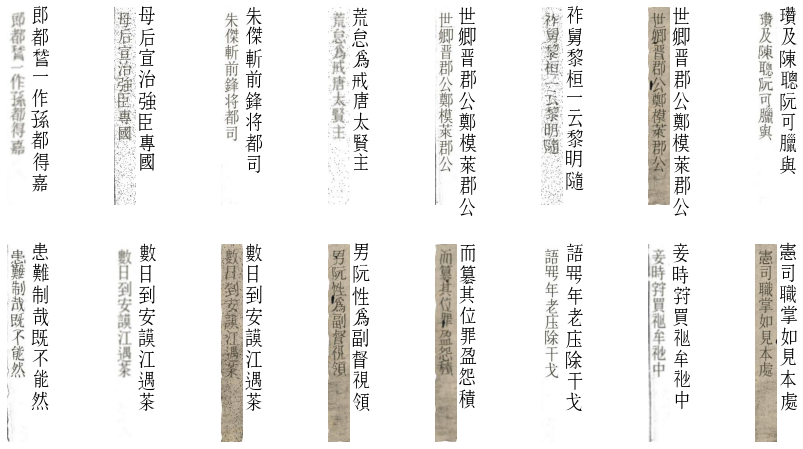

In [8]:
from visualizer import visualize_images_labels
visualize_images_labels(
    dataset.img_paths, 
    dataset.labels, 
    figsize = (15, 8),
    subplot_size = (2, 8),
    font_path = FONT_PATH
)

# Define model components

In [9]:
from tensorflow.keras.layers import Input, Embedding, Dense, GRU, Concatenate, Flatten
from layers import custom_cnn, reshape_features, BahdanauAttention
EMBEDDING_DIM = 512
UNITS = 1024

## The encoder

In [10]:
def Encoder(imagenet_model=None, imagenet_output_layer=None, name='Encoder'):
    if imagenet_model: # Use Imagenet model as CNN layers
        image_input = imagenet_model.input
        imagenet_model.layers[0]._name = 'image'
        features = imagenet_model.get_layer(imagenet_output_layer).output
    else: 
        image_input = Input(shape=(HEIGHT, WIDTH, 3), dtype='float32', name='image')
        conv_blocks_config = {
            'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)}, 
            'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)}, 
            'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)}, 
            'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (2, 2)}, 
            
            # Last Conv blocks with 2x2 kernel but without no padding and pooling layer
            'block5': {'num_conv': 2, 'filters': 512, 'pool_size': None}, 
        }
        features = custom_cnn(conv_blocks_config, image_input)

    # Adding pixel coordinates to image features
    batch_size, h, w, _ = tf.shape(features)
    x, y = tf.meshgrid(tf.range(w), tf.range(h))
    w_loc = tf.one_hot(x, depth=w)
    h_loc = tf.one_hot(y, depth=h)
    loc = tf.concat([h_loc, w_loc], axis=2)
    loc = tf.tile(tf.expand_dims(loc, 0), multiples=[batch_size, 1, 1, 1])
    
    # (batch_size, height, width, num_features + coord)
    features = tf.concat([features, loc], axis=3) 
    features = reshape_features(features, dim_to_keep=1, name='rnn_input')
    return tf.keras.Model(inputs=image_input, outputs=features, name=name)

## The decoder

In [11]:
def Decoder(enc_features_shape, name='Decoder'):
    token_input = Input(shape=(1,), name='new_token')
    features_input = Input(shape=enc_features_shape, name='encoder_features')
    pre_hidden_input = Input(shape=(UNITS,), name='previous_state')
    
    # Defining attention as a separate model
    attention = BahdanauAttention(UNITS)
    context_vector, attention_weights = attention(features_input, pre_hidden_input)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = Concatenate(axis=-1, name='context_and_embedding')([
        tf.expand_dims(context_vector, 1), 
        Embedding(VOCAB_SIZE, EMBEDDING_DIM)(token_input)
    ])
    
    # Passing the concatenated vector to the GRU
    rnn_output, state = GRU(
        units = UNITS, 
        return_state = True, 
        return_sequences = True, 
        name = 'dec_gru'
    )(x, initial_state=pre_hidden_input)

    # Generate predictions
    x = Flatten()(Dense(UNITS)(rnn_output))
    y_pred = Dense(VOCAB_SIZE, name='prediction')(x)

    return tf.keras.Model(
        inputs = [token_input, features_input, pre_hidden_input], 
        outputs = [y_pred, state, attention_weights],
        name = name
    )

# Build the model

In [12]:
from models import get_imagenet_model, EncoderDecoderModel
imagenet_model, imagenet_output_layer = None, None
# # Pick a model from https://keras.io/api/applications
# imagenet_model = get_imagenet_model('VGG16', (HEIGHT, WIDTH, 3))
# imagenet_output_layer = 'block5_pool'
# imagenet_model.summary(line_length=100)

In [13]:
encoder = Encoder(imagenet_model, imagenet_output_layer)
decoder = Decoder(encoder.output_shape[1:])
model = EncoderDecoderModel(encoder, decoder, data_handler, dec_rnn_name='dec_gru')

In [14]:
encoder.summary(line_length=120)
print()
decoder.summary(line_length=125)

Model: "Encoder"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 image (InputLayer)                    [(None, 432, 48, 3)]       0             []                                      
                                                                                                                        
 block1_conv1 (Conv2D)                 (None, 432, 48, 64)        1792          ['image[0][0]']                         
                                                                                                                        
 block1_bn1 (BatchNormalization)       (None, 432, 48, 64)        256           ['block1_conv1[0][0]']                  
                                                                                                                        
 block1_relu1 (

                                                                                                                        
 tf.range (TFOpLambda)                 (1,)                       0             ['tf.__operators__.getitem_2[0][0]']    
                                                                                                                        
 tf.range_1 (TFOpLambda)               (25,)                      0             ['tf.__operators__.getitem_1[0][0]']    
                                                                                                                        
 tf.meshgrid (TFOpLambda)              [(25, 1),                  0             ['tf.range[0][0]',                      
                                        (25, 1)]                                 'tf.range_1[0][0]']                    
                                                                                                                        
 tf.one_hot_1 (TFOpLambda)      

# Training

In [15]:
train_idxs = list(range(int(dataset.size * 0.8)))
valid_idxs = list(range(train_idxs[-1] + 1, dataset.size))
print('Number of training samples:', len(train_idxs))
print('Number of validate samples:', len(valid_idxs))

Number of training samples: 81226
Number of validate samples: 20307


In [16]:
import random
random.seed(2022)
random.shuffle(train_idxs)

# When run on a small RAM machine, you can set use_cache=False to 
# not run out of memory but it will slow down the training speed
train_tf_dataset = data_handler.prepare_tf_dataset(train_idxs, BATCH_SIZE, drop_remainder=True)
valid_tf_dataset = data_handler.prepare_tf_dataset(valid_idxs, BATCH_SIZE, drop_remainder=True)

## Callbacks

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping_callback = EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 1e-3, # Change that less than 1e-3, will count as no improvement
    patience = 5, # Stop if no improvement after 5 epochs
    restore_best_weights = True, # Restore weights from the epoch with the best value
    verbose = 1
)

# Reduce the learning rate once learning stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 2, # Reduce if no improvement after 2 epochs
    min_lr = 1e-6, # Lower bound on the learning rate 
    factor = 0.5, # => new_lr = lr * factor
    verbose = 1
)

## Train the IHR-NomDB dataset

In [18]:
from losses import MaskedLoss
from metrics import SequenceAccuracy, CharacterAccuracy, LevenshteinDistance
from tensorflow.keras.optimizers import Adam
LEARNING_RATE = 2e-4
EPOCHS = 100

In [19]:
model.compile(
    optimizer = Adam(LEARNING_RATE), 
    loss = MaskedLoss(), 
    metrics = [
        SequenceAccuracy(),
        CharacterAccuracy(),
        LevenshteinDistance(normalize=True, name='lev_distance')
    ]
)

In [20]:
%%time
history = model.fit(
    train_tf_dataset,
    validation_data = valid_tf_dataset,
    epochs = EPOCHS,
    callbacks = [reduce_lr_callback, early_stopping_callback],
    verbose = 1
).history

Epoch 1/100
2538/2538 [==============================] - 426s 162ms/step - loss: 4.3373 - seq_acc: 3.6939e-05 - char_acc: 0.1682 - lev_distance: 0.7489 - val_loss: 4.6533 - val_seq_acc: 0.0000e+00 - val_char_acc: 0.1914 - val_lev_distance: 0.7939 - lr: 2.0000e-04
Epoch 2/100
2538/2538 [==============================] - 398s 157ms/step - loss: 1.9791 - seq_acc: 0.0365 - char_acc: 0.4961 - lev_distance: 0.4879 - val_loss: 1.3808 - val_seq_acc: 0.0304 - val_char_acc: 0.5032 - val_lev_distance: 0.4390 - lr: 2.0000e-04
Epoch 3/100
2538/2538 [==============================] - 398s 157ms/step - loss: 0.6282 - seq_acc: 0.2580 - char_acc: 0.8065 - lev_distance: 0.1908 - val_loss: 0.5761 - val_seq_acc: 0.1778 - val_char_acc: 0.7615 - val_lev_distance: 0.2279 - lr: 2.0000e-04
Epoch 4/100
2538/2538 [==============================] - 398s 157ms/step - loss: 0.3095 - seq_acc: 0.4559 - char_acc: 0.8903 - lev_distance: 0.1093 - val_loss: 0.3825 - val_seq_acc: 0.2783 - val_char_acc: 0.8441 - val_lev_di

## Save the training results

In [21]:
best_epoch = early_stopping_callback.best_epoch
print(f'- Loss on validation\t: {history["val_loss"][best_epoch]}')
print(f'- Sequence accuracy\t: {history["val_seq_acc"][best_epoch]}')
print(f'- Character accuracy\t: {history["val_char_acc"][best_epoch]}')
print(f'- Levenshtein distance\t: {history["val_lev_distance"][best_epoch]}')

- Loss on validation	: 0.05052793025970459
- Sequence accuracy	: 0.7759759426116943
- Character accuracy	: 0.972908616065979
- Levenshtein distance	: 0.025249673053622246


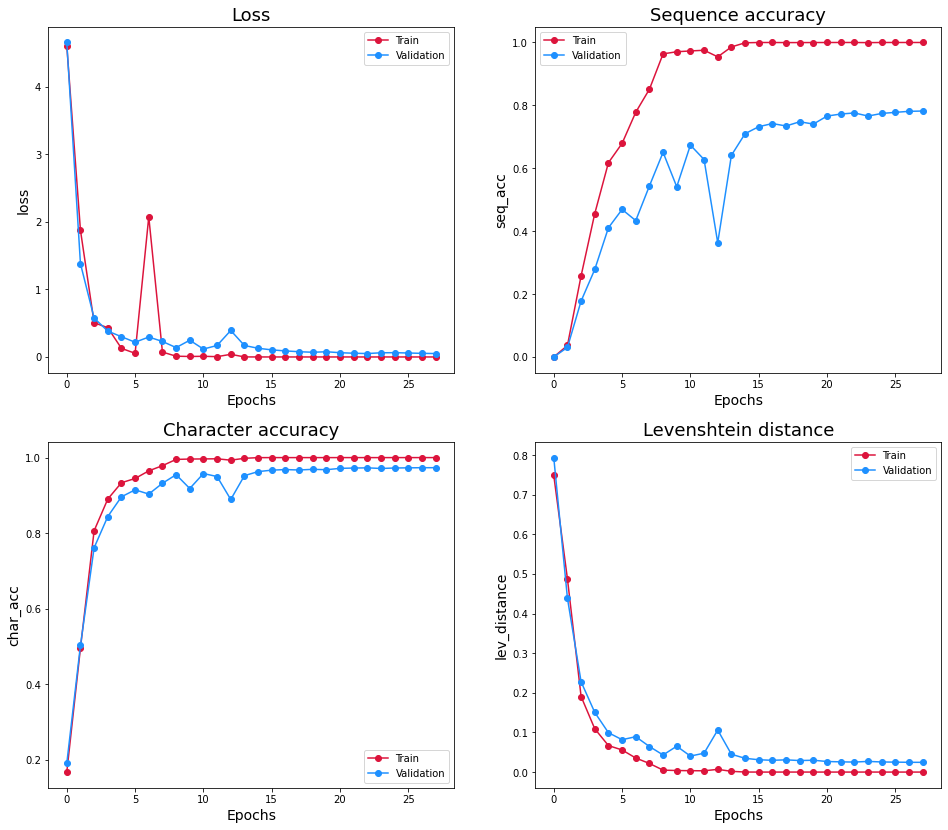

In [22]:
from visualizer import plot_training_results
plot_training_results(history, f'{APPROACH_NAME}.png')
model.encoder.save_weights(f'{APPROACH_NAME}_encoder.h5')
model.decoder.save_weights(f'{APPROACH_NAME}_decoder.h5')

# Inference

In [23]:
encoder = Encoder(imagenet_model, imagenet_output_layer)
decoder = Decoder(encoder.output_shape[1:])
encoder.load_weights(f'{APPROACH_NAME}_encoder.h5')
decoder.load_weights(f'{APPROACH_NAME}_decoder.h5')

In [24]:
reset_model = EncoderDecoderModel(encoder, decoder, data_handler, dec_rnn_name='dec_gru')
reset_model.compile(
    optimizer = Adam(LEARNING_RATE), 
    loss = MaskedLoss(), 
    metrics = [
        SequenceAccuracy(),
        CharacterAccuracy(),
        LevenshteinDistance(normalize=True, name='lev_distance')
    ]
)
reset_model.evaluate(valid_tf_dataset)

634/634 [==============================] - 54s 74ms/step - loss: 0.2380 - seq_acc: 0.7760 - char_acc: 0.9729 - lev_distance: 0.0252


[0.7759759426116943,
 0.972908616065979,
 0.025249673053622246,
 0.05052793025970459]

## On test dataset

Batch 01:
- True: {1: '㙋𡉖\U000f0b1f', 2: '噙𠿒', 3: '犝犠', 4: '鉸𨦀', 5: '爲䧺禮公而不委之以兵', 6: '爲䧺禮公而不委之以兵', 7: '是以聖帝明王之治天下', 8: '十一月戊子朔日有食之', 9: '以致敗人事者自古有之', 10: '不名以激年老之固位者', 11: '璉以是不平使人陰殺之', 12: '武郡公令人以象載之及', 13: '武郡公令人以象載之及', 14: '大而三綱五常之道以至', 15: '世人以不常見而異之殊', 16: '如先求皇子而立之以安', 17: '如先求皇子而立之以安', 18: '冬十一月帝得陳暠立之', 19: '中國之人不耐其水土也', 20: '首惡之名為人臣而不知', 21: '爲悅而不知其過之大也', 22: '帝位以副天下臣民之望', 23: '食之是月會試天下士人', 24: '十二月以誕日為建天節', 25: '春正月初二日上以大軍', 26: '取士之科不一而定三年', 27: '取之以賴其後故有是命', 28: '人守之百官進朝不得入', 29: '牧之民不足以煩中國也', 30: '罄家所有以奉事之冀其', 31: '土人以為灵異立祠事之', 32: '土人以為灵異立祠事之'}
- Pred: {1: '堪呂地', 2: '噒\U000f0949', 3: '撞𢮿', 4: '鈘\U000f1907', 5: '爲䧺禮公而不委之以兵', 6: '爲䧺禮公而不委之以兵', 7: '是以聖帝明王之治天下', 8: '十丈月戊子朔日有食之', 9: '以致敗人事者自古有之', 10: '不名以激年老之固位者', 11: '璉以是不平使人陰殺之', 12: '武郡公令人以象載之及', 13: '武郡公令人以象載之及', 14: '大而三綱五常之道正至', 15: '世人以不常見而異之戌', 16: '如先求皇子而立之以安', 17: '如先求皇子而立之以安', 18: '冬十一月帝得陳舊之之', 19: '中國之人不耐其水土也', 20: '首惡之名為人臣而不知', 21: '爲悅而不知其過之大也', 22: '帝位以副天下臣民之望', 23: '食之是月會試天下士人', 24: '十二月以誕日為建天節', 25: '春正月初二日上八大軍',

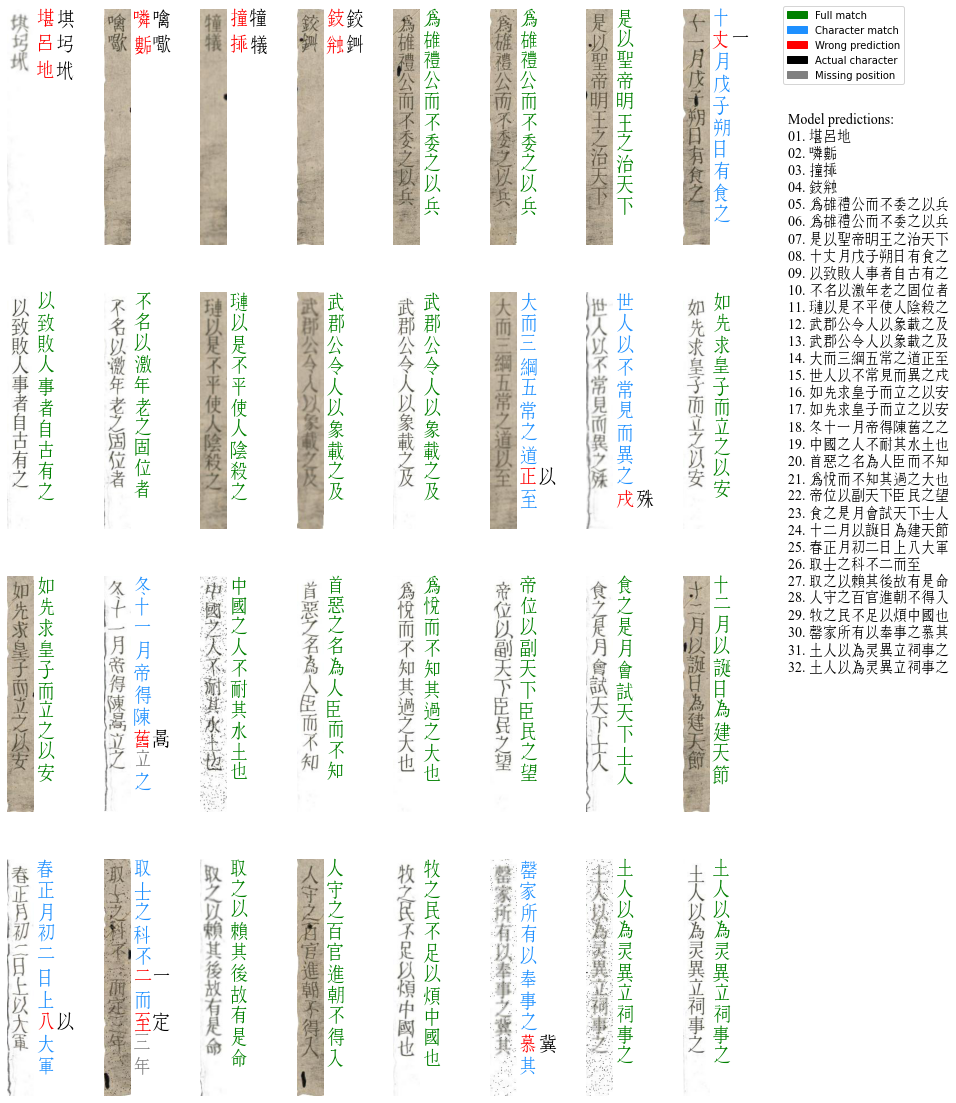

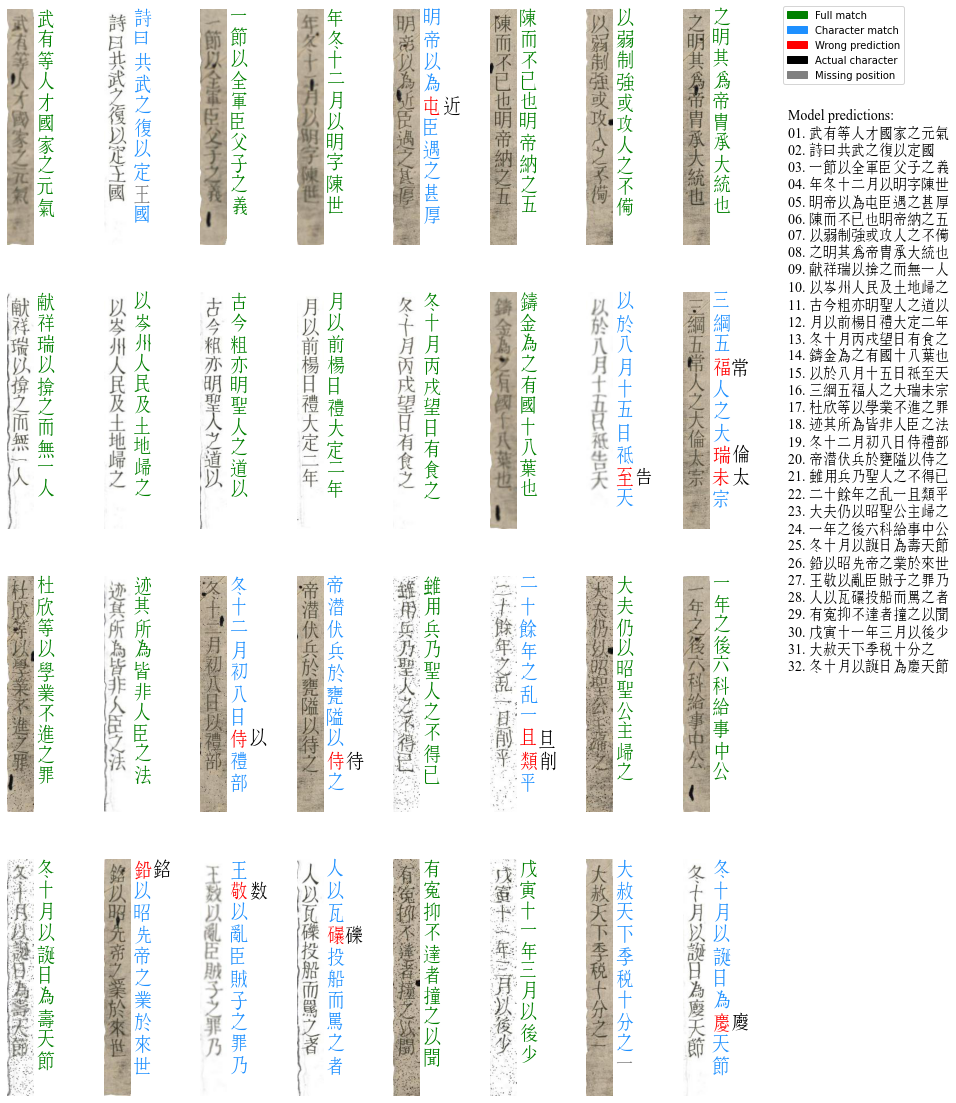

In [25]:
batch_results = []
for idx, (batch_images, batch_tokens) in enumerate(valid_tf_dataset.take(2)):
    idxs_in_batch = valid_idxs[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE]
    labels = data_handler.tokens2texts(batch_tokens)
    pred_tokens, attentions = reset_model.predict(batch_images, return_attention=True)
    pred_labels = data_handler.tokens2texts(pred_tokens)
    
    batch_results.append({'true': labels, 'pred': pred_labels, 'attentions': attentions})
    visualize_images_labels(
        img_paths = dataset.img_paths[idxs_in_batch], 
        labels = labels, 
        pred_labels = pred_labels,
        figsize = (14, 20),
        subplot_size = (4, 8),
        legend_loc = (3.8, 4.28),
        annotate_loc = (4, 1.8),
        font_path = FONT_PATH, 
    )
    print(
        f'Batch {idx + 1:02d}:\n'
        f'- True: {dict(enumerate(labels, start=1))}\n'
        f'- Pred: {dict(enumerate(pred_labels, start=1))}\n'
    )

## On random image

In [26]:
random_path = '../囷𦝄苔惮󰞺𧍋𦬑囊.jpg'
random_label = '囷𦝄苔惮󰞺𧍋𦬑囊'
random_image = data_handler.process_image(random_path)
pred_tokens = reset_model.predict(tf.expand_dims(random_image, axis=0))
pred_labels = data_handler.tokens2texts(pred_tokens)

Predicted text: 囷𦝄仝惮麻𢫞𣈜𦬑囊


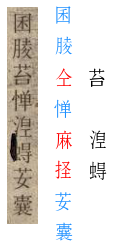

In [27]:
visualize_images_labels(
    img_paths = [random_path], 
    labels = [random_label], 
    pred_labels = pred_labels,
    figsize = (5, 4),
    subplot_size = (1, 1), 
    font_path = FONT_PATH, 
)
print('Predicted text:', ''.join(pred_labels))